### Financial Index Prediction
This notebook seeks to predict the direction of a financial index from day k to day k+1 given financial news headlines from day k. A range of different combinations between statistical and NLP-models are used. 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from sklearn.utils import parallel_backend
from pathlib import Path
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, f1_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import svm
from sklearn.dummy import DummyClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

#### Load financial news data and financial index data

In [3]:
ONEDRIVE_PATH = Path(r"C:\Users\gusta\Kidbrooke Advisory Ab\KidbrookeOneDrive - Gustaf Backman exjobb")

# Read the financial data
fin_path = ONEDRIVE_PATH / "Input Data/stock_data.pkl"
fin_data = pd.read_pickle(fin_path)
# Read from 2006-10-20 for next day preds, or 10-19 for present day preds
fin_data = fin_data.loc['2006-10-20' : '2013-11-20']

news_path = ONEDRIVE_PATH / "Input Data/financial_headlines_20061020-20131119.pkl"
news_data = pd.DataFrame(pd.read_pickle(news_path))
news_data.set_index('date',inplace=True)

In [4]:
news_dates = news_data.index.drop_duplicates()
fin_dates = fin_data.index.drop_duplicates()

# Find the dates which are present in both the financial data and news data
valid_dates = []
for date in news_dates: 
    if date in fin_data.index: 
        valid_dates.append(date)
valid_dates.append(fin_data.index[-1]) # Add the last index in fin_data and remove after creating targets
# Create targets for all 3 time series 
targets = pd.DataFrame(dtype='int8')
prev_vals = fin_data.iloc[0]
for date in tqdm(valid_dates[1:]): # The first date is fin_data.iloc[0] 
    y_temp = []
    # If the value has increased since yesterday, y = 1
    if prev_vals['1 YEAR'] < fin_data.loc[date]['1 YEAR']: 
        y_temp.append(1)
    else:
        y_temp.append(0)
        
    if prev_vals['3 YEAR'] < fin_data.loc[date]['3 YEAR']: 
        y_temp.append(1)
    else:
        y_temp.append(0)
        
    if prev_vals['S&P'] < fin_data.loc[date]['S&P']: 
        y_temp.append(1)
    else:
        y_temp.append(0)
    targets = targets.append({'1 YEAR':y_temp[0], '3 YEAR':y_temp[1], 'S&P':y_temp[2]}, ignore_index=True)
    prev_vals = fin_data.loc[date]
valid_dates.remove(fin_data.index[-1]) # Remove since this date is not present in news data


100%|█████████████████████████████████████████████████████████████████████████████| 1846/1846 [00:03<00:00, 484.73it/s]


In [5]:
# Concatenate the news for each day in the valid indices, i.e. the indices that are present in both 
# the financial data and the news data 
texts = []
for date in tqdm(valid_dates): 
    temp_texts = ""
    for i,text in enumerate(news_data.loc[date]['title']): 
        if i < len(news_data.loc[date]['title']) - 1:
            temp_texts += text + ". "
        else:
            temp_texts += text
    texts.append(temp_texts)
texts = np.asarray(texts)
print("Length of texts:",len(texts))
print("Length of targets:",len(targets))
n = len(targets)

100%|██████████████████████████████████████████████████████████████████████████████| 1846/1846 [00:39<00:00, 46.36it/s]

Length of texts: 1846
Length of targets: 1846


#### Format the text with tf-idf
The texts have now been separated into entries in a arrays for training and testing. The next step is to transform these entries into vectors using TF-IDF. 

In [6]:
# Create a matrix with the frequency of a word in each day.
count_vec = CountVectorizer(max_features=10000) # Includes only the 10000 most frequent words 
count_vec.fit(texts)

x_count = count_vec.transform(texts)
x_count = count_vec.transform(texts)

# Create a matrix with the tfidf representation of the text
tfidf_vec = TfidfTransformer()
tfidf_vec.fit(x_count)
x = tfidf_vec.transform(x_count)

#### Partition into training and test set
The data is partitioned to a training and a test set, where the distribution of labels are respected.

In [7]:
zero_indices_1yr = np.where(targets['1 YEAR'] == 0)[0]
one_indices_1yr = np.where(targets['1 YEAR'] == 1)[0]

zero_indices_3yr = np.where(targets['3 YEAR'] == 0)[0]
one_indices_3yr = np.where(targets['3 YEAR'] == 1)[0]

zero_indices_sp = np.where(targets['S&P'] == 0)[0]
one_indices_sp = np.where(targets['S&P'] == 1)[0]

print(" ----- 1 YEAR RATE -----")
print("Ratio neg labels 1 year rate:",len(zero_indices_1yr) / len(targets))
print("Neg labels:", len(zero_indices_1yr), "Pos labels:",len(one_indices_1yr))
print(" ----- 3 YEAR RATE -----")
print("Ratio neg labels 3 year rate:",len(zero_indices_3yr) / len(targets))
print("Neg labels:", len(zero_indices_3yr), "Pos labels:",len(one_indices_3yr))
print(" -----     S&P     -----")
print("Ratio neg labels S&P:",len(zero_indices_sp) / len(targets))
print("Neg labels:", len(zero_indices_sp), "Pos labels:",len(one_indices_sp))

 ----- 1 YEAR RATE -----
Ratio neg labels 1 year rate: 0.6885157096424702
Neg labels: 1271 Pos labels: 575
 ----- 3 YEAR RATE -----
Ratio neg labels 3 year rate: 0.594257854821235
Neg labels: 1097 Pos labels: 749
 -----     S&P     -----
Ratio neg labels S&P: 0.4647887323943662
Neg labels: 858 Pos labels: 988


In [8]:
n_train = 1200
n = len(targets)

np.random.shuffle(zero_indices_1yr)
np.random.shuffle(one_indices_1yr)
part_zeros_1yr = len(zero_indices_1yr) / n
train_indices_1yr = np.zeros((n_train),dtype=int)
train_indices_1yr[:round(part_zeros_1yr * n_train)] = zero_indices_1yr[:round(part_zeros_1yr * n_train)]
train_indices_1yr[round(part_zeros_1yr * n_train):] = one_indices_1yr[:round((1 - part_zeros_1yr) * n_train)]
np.random.shuffle(train_indices_1yr)
# All indices not in train is in test. 
test_indices_1yr = np.setdiff1d(np.arange(len(targets)), train_indices_1yr)
np.random.shuffle(test_indices_1yr)

np.random.shuffle(zero_indices_3yr)
np.random.shuffle(one_indices_3yr)
part_zeros_3yr = len(zero_indices_3yr) / n
train_indices_3yr = np.zeros((n_train),dtype=int)
train_indices_3yr[:round(part_zeros_3yr * n_train)] = zero_indices_3yr[:round(part_zeros_3yr * n_train)]
train_indices_3yr[round(part_zeros_3yr * n_train):] = one_indices_3yr[:round((1 - part_zeros_3yr) * n_train)]
np.random.shuffle(train_indices_3yr)
# All indices not in train is in test. 
test_indices_3yr = np.setdiff1d(np.arange(len(targets)), train_indices_3yr)
np.random.shuffle(test_indices_3yr)

np.random.shuffle(zero_indices_sp)
np.random.shuffle(one_indices_sp)
part_zeros_sp = len(zero_indices_sp) / n
train_indices_sp = np.zeros((n_train),dtype=int)
train_indices_sp[:round(part_zeros_sp * n_train)] = zero_indices_sp[:round(part_zeros_sp * n_train)]
train_indices_sp[round(part_zeros_sp * n_train):] = one_indices_sp[:round((1 - part_zeros_sp) * n_train)]
np.random.shuffle(train_indices_sp)
# All indices not in train is in test. 
test_indices_sp = np.setdiff1d(np.arange(len(targets)), train_indices_sp)
np.random.shuffle(test_indices_sp)

texts_train_1yr = texts[train_indices_1yr]
texts_test_1yr = texts[test_indices_1yr]
x_train_1yr = x[train_indices_1yr]
x_test_1yr = x[test_indices_1yr]
y_train_1yr = targets.iloc[train_indices_1yr]['1 YEAR'].values
y_test_1yr = targets.iloc[test_indices_1yr]['1 YEAR'].values

texts_train_3yr = texts[train_indices_3yr]
texts_test_3yr = texts[test_indices_3yr]
x_train_3yr = x[train_indices_3yr]
x_test_3yr = x[test_indices_3yr]
y_train_3yr = targets.iloc[train_indices_3yr]['3 YEAR'].values
y_test_3yr = targets.iloc[test_indices_3yr]['3 YEAR'].values

texts_train_sp = texts[train_indices_sp]
texts_test_sp = texts[test_indices_sp]
x_train_sp = x[train_indices_sp]
x_test_sp = x[test_indices_sp]
y_train_sp = targets.iloc[train_indices_sp]['S&P'].values
y_test_sp = targets.iloc[test_indices_sp]['S&P'].values

# Sanity check of shapes 

print(" ----- 1 YEAR RATE -----")
print("Train data shape (x,y):",x_train_1yr.shape,",", y_train_1yr.shape)
print("Train data label ratio (0 / 1):",np.sum(y_train_1yr == 0),"/", np.sum(y_train_1yr == 1))
print("Test data shape (x,y):",x_test_1yr.shape,",", y_test_1yr.shape)
print("Test data label ratio (0 / 1):",np.sum(y_test_1yr == 0),"/", np.sum(y_test_1yr == 1))

print(" ----- 3 YEAR RATE -----")
print("Train data shape (x,y):",x_train_3yr.shape,",", y_train_3yr.shape)
print("Train data label ratio (0 / 1):",np.sum(y_train_3yr == 0),"/", np.sum(y_train_3yr == 1))
print("Test data shape (x,y):",x_test_3yr.shape,",", y_test_3yr.shape)
print("Test data label ratio (0 / 1):",np.sum(y_test_3yr == 0),"/", np.sum(y_test_3yr == 1))
print(" -----     S&P     -----")
print("Train data shape (x,y):",x_train_sp.shape,",", y_train_sp.shape)
print("Train data label ratio (0 / 1):",np.sum(y_train_sp == 0),"/", np.sum(y_train_sp == 1))
print("Test data shape (x,y):",x_test_sp.shape,",", y_test_sp.shape)
print("Test data label ratio (0 / 1):",np.sum(y_test_sp == 0),"/", np.sum(y_test_sp == 1))

 ----- 1 YEAR RATE -----
Train data shape (x,y): (1200, 10000) , (1200,)
Train data label ratio (0 / 1): 826 / 374
Test data shape (x,y): (646, 10000) , (646,)
Test data label ratio (0 / 1): 445 / 201
 ----- 3 YEAR RATE -----
Train data shape (x,y): (1200, 10000) , (1200,)
Train data label ratio (0 / 1): 713 / 487
Test data shape (x,y): (646, 10000) , (646,)
Test data label ratio (0 / 1): 384 / 262
 -----     S&P     -----
Train data shape (x,y): (1200, 10000) , (1200,)
Train data label ratio (0 / 1): 558 / 642
Test data shape (x,y): (646, 10000) , (646,)
Test data label ratio (0 / 1): 300 / 346


## Models 
The data has been pre-processed and the models can be evaluated. All of the models are fitted with the three data series. 

In [10]:
# Some help functions for plotting the results 

def plot_results(model,x_test, y_test,save=False, name=''):
    y_test_preds = model.predict(x_test)
    print(classification_report(y_test, y_test_preds))
    print("Test accuracy:",model.score(x_test, y_test))
    plot_confusion_matrix(model,x_test,y_test)
    if save:
        plt.savefig("Figs TF-IDF/" + name + "confmat.jpg")
    plt.show()
    
def plot_results_nn(history, model,x_test, y_test,save=False, name=''):
    plt.subplot(121)
    plt.plot(history.history['loss'],label='Loss')
    plt.plot(history.history['val_loss'],label='Val loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(history.history['acc'],label='Acc')
    plt.plot(history.history['val_acc'],label='Val acc')
    plt.legend()
    if save: 
        plt.savefig("Figs TF-IDF/" + name + "history.jpg")
    plt.show() 
    y_test_pred = np.round(model.predict(x_test.todense()))
    plt.subplot(121)
    plt.bar([0,1],[np.sum(y_test == 0), np.sum(y_test == 1)], label='Actual test dist')
    plt.legend()
    plt.xticks([0, 1])
    plt.subplot(122)
    plt.bar([0,1],[np.sum(y_test_pred == 0), np.sum(y_test_pred == 1)], label='Pred test dist')
    plt.legend()
    plt.xticks([0, 1])
    plt.show()
    conf_mat = confusion_matrix(y_test,y_test_pred,normalize='pred')
    ax = sn.heatmap(conf_mat,)
    ax.set_ylabel("True values")
    ax.set_xlabel("Predicted values")
    if save: 
        plt.savefig("Figs TF-IDF/" + name + "confmat.jpg")
    plt.show()
    print(classification_report(y_test, y_test_pred))
    print("Test accuracy:",round(np.sum(y_test == y_test_pred[:,0]) / len(y_test),3))

### Random Classifier
Just for real simple comparison. 
#### 1 year rate

              precision    recall  f1-score   support

         0.0       0.67      0.68      0.67       445
         1.0       0.26      0.25      0.25       201

    accuracy                           0.54       646
   macro avg       0.46      0.46      0.46       646
weighted avg       0.54      0.54      0.54       646

Test accuracy: 0.5526315789473685


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


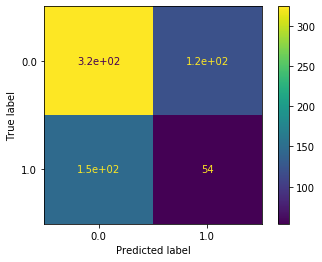

In [11]:
# Dummy Classifier
dummy_clf_1yr = DummyClassifier().fit(x_train_1yr, y_train_1yr)
plot_results(dummy_clf_1yr, x_test_1yr, y_test_1yr,save=True,name='randclf_1yr')

#### 3 year rate

              precision    recall  f1-score   support

         0.0       0.60      0.60      0.60       384
         1.0       0.42      0.42      0.42       262

    accuracy                           0.52       646
   macro avg       0.51      0.51      0.51       646
weighted avg       0.53      0.52      0.53       646

Test accuracy: 0.5356037151702786


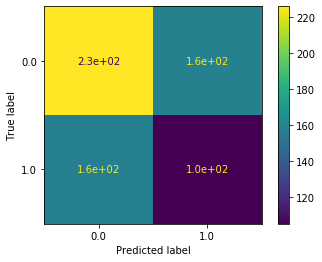

In [10]:
# Dummy Classifier
dummy_clf_3yr = DummyClassifier().fit(x_train_3yr, y_train_3yr)
plot_results(dummy_clf_3yr, x_test_3yr, y_test_3yr,save=True,name='randclf_3yr')

#### S&P

              precision    recall  f1-score   support

         0.0       0.48      0.47      0.47       300
         1.0       0.55      0.56      0.55       346

    accuracy                           0.52       646
   macro avg       0.51      0.51      0.51       646
weighted avg       0.51      0.52      0.52       646

Test accuracy: 0.5061919504643962


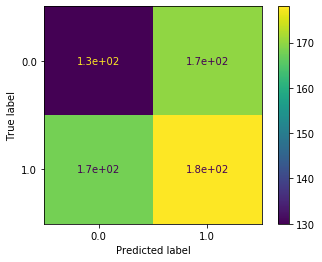

In [11]:
# Dummy Classifier
dummy_clf_sp = DummyClassifier().fit(x_train_sp, y_train_sp)
plot_results(dummy_clf_sp, x_test_sp, y_test_sp,save=True,name='randclf_sp')

### Logistic Regression with TF-IDF
#### 1 year rate

              precision    recall  f1-score   support

         0.0       0.69      1.00      0.81       445
         1.0       0.00      0.00      0.00       201

    accuracy                           0.69       646
   macro avg       0.34      0.50      0.41       646
weighted avg       0.47      0.69      0.56       646

Test accuracy: 0.6873065015479877


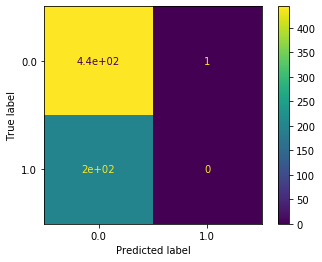

In [12]:
# Logistic regression
logreg_1yr = LogisticRegression(random_state=0).fit(x_train_1yr, y_train_1yr)
plot_results(logreg_1yr,x_test_1yr, y_test_1yr,save=True,name='logreg_1yr')

#### 3 year rate

              precision    recall  f1-score   support

         0.0       0.60      0.94      0.73       384
         1.0       0.46      0.07      0.13       262

    accuracy                           0.59       646
   macro avg       0.53      0.51      0.43       646
weighted avg       0.54      0.59      0.49       646

Test accuracy: 0.5897832817337462


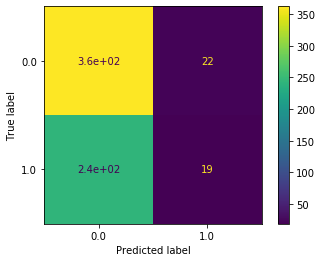

In [13]:
# Logistic regression
logreg_3yr = LogisticRegression(random_state=0).fit(x_train_3yr, y_train_3yr)
plot_results(logreg_3yr,x_test_3yr, y_test_3yr,save=True,name='logreg_3yr')

#### S&P

              precision    recall  f1-score   support

         0.0       0.50      0.24      0.32       300
         1.0       0.54      0.79      0.64       346

    accuracy                           0.53       646
   macro avg       0.52      0.51      0.48       646
weighted avg       0.52      0.53      0.50       646

Test accuracy: 0.5340557275541795


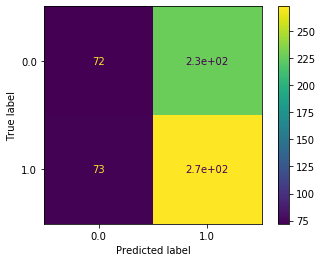

In [14]:
# Logistic regression
logreg_sp = LogisticRegression(random_state=0).fit(x_train_sp, y_train_sp)
plot_results(logreg_sp,x_test_sp, y_test_sp,save=True,name='logreg_sp')

### Support Vector Machine with TF-IDF
#### 1 year rate

              precision    recall  f1-score   support

         0.0       0.69      1.00      0.81       445
         1.0       0.00      0.00      0.00       201

    accuracy                           0.69       646
   macro avg       0.34      0.50      0.41       646
weighted avg       0.47      0.69      0.56       646

Test accuracy: 0.6857585139318886


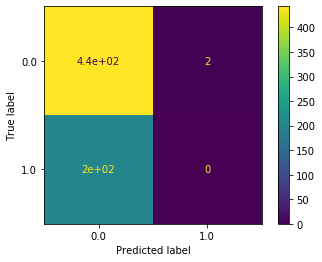

In [15]:
svm_clf_1yr = svm.SVC().fit(x_train_1yr, y_train_1yr)
plot_results(svm_clf_1yr, x_test_1yr, y_test_1yr,save=True,name='svm_1yr')

#### 3 year rate

              precision    recall  f1-score   support

         0.0       0.59      0.98      0.74       384
         1.0       0.14      0.00      0.01       262

    accuracy                           0.59       646
   macro avg       0.37      0.49      0.37       646
weighted avg       0.41      0.59      0.44       646

Test accuracy: 0.586687306501548


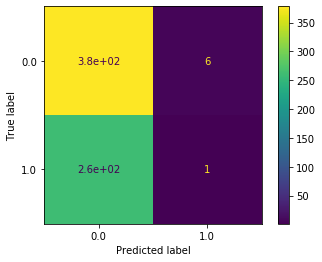

In [16]:
svm_clf_3yr = svm.SVC().fit(x_train_3yr, y_train_3yr)
plot_results(svm_clf_3yr, x_test_3yr, y_test_3yr,save=True,name='svm_3yr')

#### S&P

              precision    recall  f1-score   support

         0.0       0.53      0.10      0.16       300
         1.0       0.54      0.92      0.68       346

    accuracy                           0.54       646
   macro avg       0.53      0.51      0.42       646
weighted avg       0.53      0.54      0.44       646

Test accuracy: 0.5402476780185759


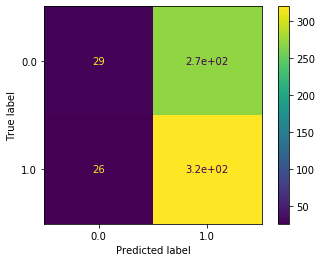

In [17]:
svm_clf_sp = svm.SVC().fit(x_train_sp, y_train_sp)
plot_results(svm_clf_sp, x_test_sp, y_test_sp,save=True,name='svm_sp')

### Random Forest with TF-IDF
#### 1 year rate

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  3.9min finished


Best: 0.688333 using {'max_depth': None, 'n_estimators': 1000}
0.686667 (0.005528) with: {'max_depth': None, 'n_estimators': 250}
0.687500 (0.005590) with: {'max_depth': None, 'n_estimators': 500}
0.687500 (0.004167) with: {'max_depth': None, 'n_estimators': 750}
0.688333 (0.004082) with: {'max_depth': None, 'n_estimators': 1000}
0.686667 (0.005528) with: {'max_depth': 50, 'n_estimators': 250}
0.687500 (0.005590) with: {'max_depth': 50, 'n_estimators': 500}
0.688333 (0.004082) with: {'max_depth': 50, 'n_estimators': 750}
0.688333 (0.004082) with: {'max_depth': 50, 'n_estimators': 1000}
0.688333 (0.004082) with: {'max_depth': 100, 'n_estimators': 250}
0.688333 (0.004082) with: {'max_depth': 100, 'n_estimators': 500}
0.688333 (0.004082) with: {'max_depth': 100, 'n_estimators': 750}
0.688333 (0.004082) with: {'max_depth': 100, 'n_estimators': 1000}


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.69      1.00      0.82       445
         1.0       0.00      0.00      0.00       201

    accuracy                           0.69       646
   macro avg       0.34      0.50      0.41       646
weighted avg       0.47      0.69      0.56       646

Test accuracy: 0.6888544891640866


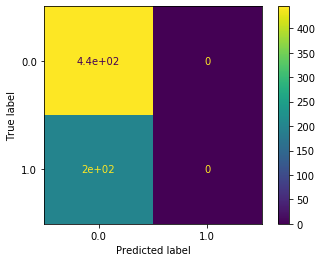

In [81]:
# Random Forest
rf_param_grid = dict(max_depth=[None, 50, 100],
                  n_estimators=[250, 500, 750, 1000, 1250, 1500, 1750, 2000])
rf_grid = GridSearchCV(estimator=RandomForestClassifier(), 
                       param_grid=rf_param_grid, 
                       n_jobs=-1, 
                       cv=10, 
                       verbose=1)
with parallel_backend('threading'):    # This is a bug work-around mentioned in https://github.com/scikit-learn/scikit-learn/issues/12546
    rf_grid_result = rf_grid.fit(x_train_1yr, y_train_1yr)
# summarize results
print("Best: %f using %s" % (rf_grid_result.best_score_, rf_grid_result.best_params_))
rf_means = rf_grid_result.cv_results_['mean_test_score']
rf_stds = rf_grid_result.cv_results_['std_test_score']
rf_params = rf_grid_result.cv_results_['params']
for mean, stdev, param in zip(rf_means, rf_stds, rf_params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Fit the model with the best parameters found in the cross validation. 
randomforest_1yr = RandomForestClassifier(max_depth=rf_grid_result.best_params_['max_depth'],
                                      n_estimators=rf_grid_result.best_params_['n_estimators']).fit(x_train_1yr, y_train_1yr)
plot_results(randomforest_1yr,x_test_1yr, y_test_1yr,save=True,name='rf_1yr_md{}_est_{}'.format(rf_grid_result.best_params_['max_depth'],
                                                                                rf_grid_result.best_params_['n_estimators']))

#### 3 year rate

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  4.3min finished


Best: 0.595833 using {'max_depth': 50, 'n_estimators': 750}
0.593333 (0.012802) with: {'max_depth': None, 'n_estimators': 250}
0.591667 (0.014907) with: {'max_depth': None, 'n_estimators': 500}
0.591667 (0.010541) with: {'max_depth': None, 'n_estimators': 750}
0.593333 (0.009718) with: {'max_depth': None, 'n_estimators': 1000}
0.586667 (0.017951) with: {'max_depth': 50, 'n_estimators': 250}
0.589167 (0.009167) with: {'max_depth': 50, 'n_estimators': 500}
0.595833 (0.006719) with: {'max_depth': 50, 'n_estimators': 750}
0.595000 (0.004082) with: {'max_depth': 50, 'n_estimators': 1000}
0.588333 (0.020480) with: {'max_depth': 100, 'n_estimators': 250}
0.586667 (0.012472) with: {'max_depth': 100, 'n_estimators': 500}
0.595000 (0.011304) with: {'max_depth': 100, 'n_estimators': 750}
0.590833 (0.008700) with: {'max_depth': 100, 'n_estimators': 1000}
              precision    recall  f1-score   support

         0.0       0.59      0.98      0.74       384
         1.0       0.14      0.00   

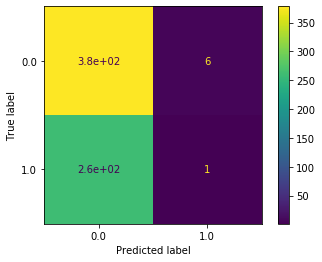

In [82]:
# Random Forest
rf_param_grid = dict(max_depth=[None, 50, 100],
                  n_estimators=[250, 500, 750, 1000, 1250, 1500, 1750, 2000])
rf_grid = GridSearchCV(estimator=RandomForestClassifier(), 
                       param_grid=rf_param_grid, 
                       n_jobs=-1, 
                       cv=10, 
                       verbose=1)
with parallel_backend('threading'):    # This is a bug work-around mentioned in https://github.com/scikit-learn/scikit-learn/issues/12546
    rf_grid_result = rf_grid.fit(x_train_3yr, y_train_3yr)
# summarize results
print("Best: %f using %s" % (rf_grid_result.best_score_, rf_grid_result.best_params_))
rf_means = rf_grid_result.cv_results_['mean_test_score']
rf_stds = rf_grid_result.cv_results_['std_test_score']
rf_params = rf_grid_result.cv_results_['params']
for mean, stdev, param in zip(rf_means, rf_stds, rf_params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Fit the model with the best parameters found in the cross validation. 
randomforest_3yr = RandomForestClassifier(max_depth=rf_grid_result.best_params_['max_depth'],
                                      n_estimators=rf_grid_result.best_params_['n_estimators']).fit(x_train_3yr, y_train_3yr)
plot_results(randomforest_3yr,x_test_3yr, y_test_3yr,save=True,name='rf_3yr_md{}_est_{}'.format(rf_grid_result.best_params_['max_depth'],
                                                                                rf_grid_result.best_params_['n_estimators']))

#### S&P

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  4.5min finished


Best: 0.533333 using {'max_depth': None, 'n_estimators': 1000}
0.524167 (0.055334) with: {'max_depth': None, 'n_estimators': 250}
0.517500 (0.033634) with: {'max_depth': None, 'n_estimators': 500}
0.528333 (0.030092) with: {'max_depth': None, 'n_estimators': 750}
0.533333 (0.035940) with: {'max_depth': None, 'n_estimators': 1000}
0.530000 (0.032956) with: {'max_depth': 50, 'n_estimators': 250}
0.519167 (0.029119) with: {'max_depth': 50, 'n_estimators': 500}
0.525000 (0.015811) with: {'max_depth': 50, 'n_estimators': 750}
0.528333 (0.024777) with: {'max_depth': 50, 'n_estimators': 1000}
0.504167 (0.041374) with: {'max_depth': 100, 'n_estimators': 250}
0.527500 (0.038197) with: {'max_depth': 100, 'n_estimators': 500}
0.520833 (0.036372) with: {'max_depth': 100, 'n_estimators': 750}
0.526667 (0.035316) with: {'max_depth': 100, 'n_estimators': 1000}
              precision    recall  f1-score   support

         0.0       0.50      0.23      0.32       300
         1.0       0.55      0.80

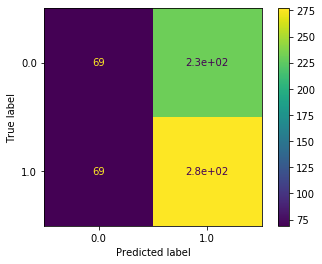

In [83]:
# Random Forest
rf_param_grid = dict(max_depth=[None, 50, 100],
                  n_estimators=[250, 500, 750, 1000, 1250, 1500, 1750, 2000])
rf_grid = GridSearchCV(estimator=RandomForestClassifier(), 
                       param_grid=rf_param_grid, 
                       n_jobs=-1, 
                       cv=10, 
                       verbose=1)
with parallel_backend('threading'):    # This is a bug work-around mentioned in https://github.com/scikit-learn/scikit-learn/issues/12546
    rf_grid_result = rf_grid.fit(x_train_sp, y_train_sp)
# summarize results
print("Best: %f using %s" % (rf_grid_result.best_score_, rf_grid_result.best_params_))
rf_means = rf_grid_result.cv_results_['mean_test_score']
rf_stds = rf_grid_result.cv_results_['std_test_score']
rf_params = rf_grid_result.cv_results_['params']
for mean, stdev, param in zip(rf_means, rf_stds, rf_params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Fit the model with the best parameters found in the cross validation. 
randomforest_sp = RandomForestClassifier(max_depth=rf_grid_result.best_params_['max_depth'],
                                      n_estimators=rf_grid_result.best_params_['n_estimators']).fit(x_train_sp, y_train_sp)
plot_results(randomforest_sp,x_test_sp, y_test_sp,save=True,name='rf_sp_md{}_est_{}'.format(rf_grid_result.best_params_['max_depth'],
                                                                                rf_grid_result.best_params_['n_estimators']))

### Neural Network

In [12]:
def create_model(nodes1=100, nodes2=50, dropout_rate=0.3, optimizer='rmsprop', learning_rate=0.001):
    if optimizer.lower() == 'rmsprop': 
        optimizer = RMSprop(learning_rate = learning_rate)
    elif optimizer.lower() == 'adam':
        optimizer = Adam(learning_rate = learning_rate)
    model = Sequential() 
    if nodes1 == 0: 
        model.add(Dense(1, input_shape=x_train_1yr.shape[1:], activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
        return model 
    model.add(Dense(nodes1, input_shape=x_train_1yr.shape[1:]))
    model.add(Dropout(dropout_rate))
    if nodes2 == 0: 
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
        return model
    model.add(Dense(nodes2))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
    return model 

def randomize_params(params, n):
    test_params = []
    for i in range(n):
        temp_par = {}
        while True: 
            for par in params: 
                temp_par.update({par: np.random.choice(params[par])})
            if temp_par not in test_params: 
                test_params.append(temp_par)
                break
    return test_params

In [ ]:
n_tests = 50
# Define possible parameters 
possible_params = dict(batch_size = [8, 16, 32],
                       nodes1 = [50, 100, 250, 500],
                       nodes2 = [0, 50, 100, 250, 500], # 0 implies only one hidden layer 
                       dropout_rate = [0.1, 0.3, 0.5],
                       learning_rate = [1e-3, 1e-4, 1e-5],
                       optimizer = ['RMSprop','Adam'])
test_params = randomize_params(possible_params, n_tests)

#### 1 year rate

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] optimizer=Adam, nodes2=50, nodes1=50, learning_rate=1e-05, epochs=5, dropout_rate=0.5, batch_size=32 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  optimizer=Adam, nodes2=50, nodes1=50, learning_rate=1e-05, epochs=5, dropout_rate=0.5, batch_size=32, score=0.677, total=  19.1s
[CV] optimizer=Adam, nodes2=50, nodes1=50, learning_rate=1e-05, epochs=5, dropout_rate=0.5, batch_size=32 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.0s remaining:    0.0s


[CV]  optimizer=Adam, nodes2=50, nodes1=50, learning_rate=1e-05, epochs=5, dropout_rate=0.5, batch_size=32, score=0.690, total=  20.0s
[CV] optimizer=Adam, nodes2=50, nodes1=50, learning_rate=1e-05, epochs=5, dropout_rate=0.5, batch_size=32 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   39.0s remaining:    0.0s


[CV]  optimizer=Adam, nodes2=50, nodes1=50, learning_rate=1e-05, epochs=5, dropout_rate=0.5, batch_size=32, score=0.693, total=  22.9s
[CV] optimizer=RMSprop, nodes2=250, nodes1=50, learning_rate=1e-05, epochs=5, dropout_rate=0.1, batch_size=32 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min remaining:    0.0s


[CV]  optimizer=RMSprop, nodes2=250, nodes1=50, learning_rate=1e-05, epochs=5, dropout_rate=0.1, batch_size=32, score=0.677, total=  23.3s
[CV] optimizer=RMSprop, nodes2=250, nodes1=50, learning_rate=1e-05, epochs=5, dropout_rate=0.1, batch_size=32 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.4min remaining:    0.0s


[CV]  optimizer=RMSprop, nodes2=250, nodes1=50, learning_rate=1e-05, epochs=5, dropout_rate=0.1, batch_size=32, score=0.690, total=  25.7s
[CV] optimizer=RMSprop, nodes2=250, nodes1=50, learning_rate=1e-05, epochs=5, dropout_rate=0.1, batch_size=32 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.9min remaining:    0.0s


[CV]  optimizer=RMSprop, nodes2=250, nodes1=50, learning_rate=1e-05, epochs=5, dropout_rate=0.1, batch_size=32, score=0.698, total=  26.6s
[CV] optimizer=RMSprop, nodes2=250, nodes1=500, learning_rate=0.001, epochs=5, dropout_rate=0.5, batch_size=8 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.3min remaining:    0.0s


[CV]  optimizer=RMSprop, nodes2=250, nodes1=500, learning_rate=0.001, epochs=5, dropout_rate=0.5, batch_size=8, score=0.608, total=  49.1s
[CV] optimizer=RMSprop, nodes2=250, nodes1=500, learning_rate=0.001, epochs=5, dropout_rate=0.5, batch_size=8 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  3.1min remaining:    0.0s


[CV]  optimizer=RMSprop, nodes2=250, nodes1=500, learning_rate=0.001, epochs=5, dropout_rate=0.5, batch_size=8, score=0.620, total=  49.3s
[CV] optimizer=RMSprop, nodes2=250, nodes1=500, learning_rate=0.001, epochs=5, dropout_rate=0.5, batch_size=8 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.9min remaining:    0.0s


[CV]  optimizer=RMSprop, nodes2=250, nodes1=500, learning_rate=0.001, epochs=5, dropout_rate=0.5, batch_size=8, score=0.670, total=  56.3s
[CV] optimizer=RMSprop, nodes2=250, nodes1=100, learning_rate=1e-05, epochs=5, dropout_rate=0.3, batch_size=32 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  4.9min remaining:    0.0s


[CV]  optimizer=RMSprop, nodes2=250, nodes1=100, learning_rate=1e-05, epochs=5, dropout_rate=0.3, batch_size=32, score=0.677, total=  43.6s
[CV] optimizer=RMSprop, nodes2=250, nodes1=100, learning_rate=1e-05, epochs=5, dropout_rate=0.3, batch_size=32 
[CV]  optimizer=RMSprop, nodes2=250, nodes1=100, learning_rate=1e-05, epochs=5, dropout_rate=0.3, batch_size=32, score=0.690, total=  50.2s
[CV] optimizer=RMSprop, nodes2=250, nodes1=100, learning_rate=1e-05, epochs=5, dropout_rate=0.3, batch_size=32 
[CV]  optimizer=RMSprop, nodes2=250, nodes1=100, learning_rate=1e-05, epochs=5, dropout_rate=0.3, batch_size=32, score=0.698, total=  58.0s
[CV] optimizer=Adam, nodes2=0, nodes1=50, learning_rate=0.0001, epochs=5, dropout_rate=0.5, batch_size=16 
[CV]  optimizer=Adam, nodes2=0, nodes1=50, learning_rate=0.0001, epochs=5, dropout_rate=0.5, batch_size=16, score=0.677, total= 1.0min
[CV] optimizer=Adam, nodes2=0, nodes1=50, learning_rate=0.0001, epochs=5, dropout_rate=0.5, batch_size=16 
[CV]  o

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 41.3min finished


Best: 0.688333 using {'optimizer': 'RMSprop', 'nodes2': 250, 'nodes1': 50, 'learning_rate': 1e-05, 'epochs': 5, 'dropout_rate': 0.1, 'batch_size': 32}
0.686667 (0.006562) with: {'optimizer': 'Adam', 'nodes2': 50, 'nodes1': 50, 'learning_rate': 1e-05, 'epochs': 5, 'dropout_rate': 0.5, 'batch_size': 32}
0.688333 (0.008250) with: {'optimizer': 'RMSprop', 'nodes2': 250, 'nodes1': 50, 'learning_rate': 1e-05, 'epochs': 5, 'dropout_rate': 0.1, 'batch_size': 32}
0.632500 (0.027003) with: {'optimizer': 'RMSprop', 'nodes2': 250, 'nodes1': 500, 'learning_rate': 0.001, 'epochs': 5, 'dropout_rate': 0.5, 'batch_size': 8}
0.688333 (0.008250) with: {'optimizer': 'RMSprop', 'nodes2': 250, 'nodes1': 100, 'learning_rate': 1e-05, 'epochs': 5, 'dropout_rate': 0.3, 'batch_size': 32}
0.688333 (0.008250) with: {'optimizer': 'Adam', 'nodes2': 0, 'nodes1': 50, 'learning_rate': 0.0001, 'epochs': 5, 'dropout_rate': 0.5, 'batch_size': 16}
0.688333 (0.008250) with: {'optimizer': 'Adam', 'nodes2': 0, 'nodes1': 500, 

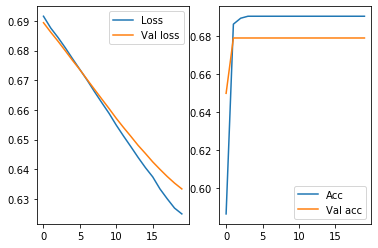

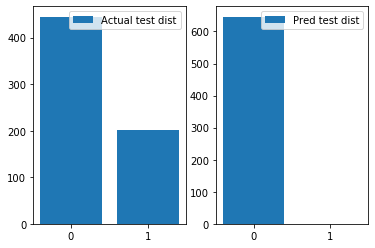

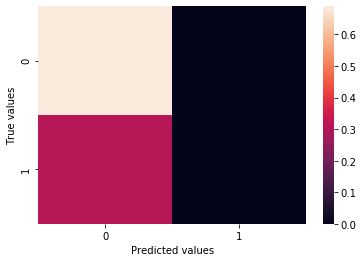

              precision    recall  f1-score   support

         0.0       0.69      1.00      0.82       445
         1.0       0.00      0.00      0.00       201

    accuracy                           0.69       646
   macro avg       0.34      0.50      0.41       646
weighted avg       0.47      0.69      0.56       646

Test accuracy: 0.689


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
historylist_1yr = []
for i,params in enumerate(tqdm(test_params)): 
    bs = params.pop('batch_size')
    model = create_model(**params)
    params.update({'batch_size': bs})
    history = model.fit(x_train_1yr, y_train_1yr,
                        epochs=10000,
                        batch_size=params['batch_size'],
                        verbose=0,
                        callbacks=[EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)],
                        validation_split=0.2)
    historylist_1yr.append(history)
max_acc_1yr = -1
max_idx_1yr = -1
for i,hist in enumerate(historylist_1yr):
    if max(hist.history['val_acc']) > max_acc_1yr: 
        max_acc_1yr = max(hist.history['val_acc'])
        max_idx_1yr = i
    
print("Best val acc:",max_acc_1yr)
print("For config: ",test_params[max_idx_1yr])


In [ ]:
bs = test_params[max_idx_1yr].pop('batch_size')
model_ff_1yr = create_model(**test_params[max_idx_1yr])
test_params[max_idx_1yr].update({'batch_size:': bs})

history_1yr = model_ff_1yr.fit(x_train_1yr, y_train_1yr,
                               epochs=100000,
                               batch_size = bs,
                               verbose=1,
                               callbacks = [Earlystopping(monitor='val_acc', patience=5, restore_best_weights=True)],
                               validation_split=0.2)
savename_1yr = "nn_bs{}_n1{}_n2{}_dr{}_lr{}_opt{}".format(test_params[max_idx_1yr]['batch_size'],
                                                          test_params[max_idx_1yr]['nodes1'],
                                                          test_params[max_idx_1yr]['nodes2'],
                                                          test_params[max_idx_1yr]['dropout_rate'],
                                                          test_params[max_idx_1yr]['learning_rate'],
                                                          test_params[max_idx_1yr]['optimizer'])
plot_results_nn(history_1yr,model_ff_1yr,x_test_1yr, y_test_1yr,save=True, name=savename_1yr)

#### 3 year rate

In [ ]:
historylist_3yr = []
for i,params in enumerate(tqdm(test_params)): 
    bs = params.pop('batch_size')
    model = create_model(**params)
    params.update({'batch_size': bs})
    history = model.fit(x_train_3yr, y_train_3yr,
                        epochs=10000,
                        batch_size=params['batch_size'],
                        verbose=0,
                        callbacks=[EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)],
                        validation_split=0.2)
    historylist_3yr.append(history)
max_acc_3yr = -1
max_idx_3yr = -1
for i,hist in enumerate(historylist_3yr):
    if max(hist.history['val_acc']) > max_acc_3yr: 
        max_acc_3yr = max(hist.history['val_acc'])
        max_idx_3yr = i
    
print("Best val acc:",max_acc_3yr)
print("For config: ",test_params[max_idx_3yr])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] optimizer=Adam, nodes2=250, nodes1=500, learning_rate=0.001, epochs=5, dropout_rate=0.1, batch_size=16 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  optimizer=Adam, nodes2=250, nodes1=500, learning_rate=0.001, epochs=5, dropout_rate=0.1, batch_size=16, score=0.535, total= 3.4min
[CV] optimizer=Adam, nodes2=250, nodes1=500, learning_rate=0.001, epochs=5, dropout_rate=0.1, batch_size=16 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min remaining:    0.0s


[CV]  optimizer=Adam, nodes2=250, nodes1=500, learning_rate=0.001, epochs=5, dropout_rate=0.1, batch_size=16, score=0.532, total= 3.8min
[CV] optimizer=Adam, nodes2=250, nodes1=500, learning_rate=0.001, epochs=5, dropout_rate=0.1, batch_size=16 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.3min remaining:    0.0s


[CV]  optimizer=Adam, nodes2=250, nodes1=500, learning_rate=0.001, epochs=5, dropout_rate=0.1, batch_size=16, score=0.515, total= 4.3min
[CV] optimizer=RMSprop, nodes2=50, nodes1=500, learning_rate=0.0001, epochs=5, dropout_rate=0.3, batch_size=16 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 11.6min remaining:    0.0s


[CV]  optimizer=RMSprop, nodes2=50, nodes1=500, learning_rate=0.0001, epochs=5, dropout_rate=0.3, batch_size=16, score=0.600, total= 4.4min
[CV] optimizer=RMSprop, nodes2=50, nodes1=500, learning_rate=0.0001, epochs=5, dropout_rate=0.3, batch_size=16 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 16.0min remaining:    0.0s


[CV]  optimizer=RMSprop, nodes2=50, nodes1=500, learning_rate=0.0001, epochs=5, dropout_rate=0.3, batch_size=16, score=0.585, total= 4.0min
[CV] optimizer=RMSprop, nodes2=50, nodes1=500, learning_rate=0.0001, epochs=5, dropout_rate=0.3, batch_size=16 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 20.0min remaining:    0.0s


[CV]  optimizer=RMSprop, nodes2=50, nodes1=500, learning_rate=0.0001, epochs=5, dropout_rate=0.3, batch_size=16, score=0.598, total= 5.0min
[CV] optimizer=Adam, nodes2=50, nodes1=500, learning_rate=1e-05, epochs=5, dropout_rate=0.3, batch_size=16 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 25.0min remaining:    0.0s


[CV]  optimizer=Adam, nodes2=50, nodes1=500, learning_rate=1e-05, epochs=5, dropout_rate=0.3, batch_size=16, score=0.598, total= 4.9min
[CV] optimizer=Adam, nodes2=50, nodes1=500, learning_rate=1e-05, epochs=5, dropout_rate=0.3, batch_size=16 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 29.9min remaining:    0.0s


[CV]  optimizer=Adam, nodes2=50, nodes1=500, learning_rate=1e-05, epochs=5, dropout_rate=0.3, batch_size=16, score=0.583, total= 4.6min
[CV] optimizer=Adam, nodes2=50, nodes1=500, learning_rate=1e-05, epochs=5, dropout_rate=0.3, batch_size=16 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 34.5min remaining:    0.0s


[CV]  optimizer=Adam, nodes2=50, nodes1=500, learning_rate=1e-05, epochs=5, dropout_rate=0.3, batch_size=16, score=0.603, total= 5.2min
[CV] optimizer=Adam, nodes2=0, nodes1=50, learning_rate=0.0001, epochs=5, dropout_rate=0.1, batch_size=8 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 39.7min remaining:    0.0s


[CV]  optimizer=Adam, nodes2=0, nodes1=50, learning_rate=0.0001, epochs=5, dropout_rate=0.1, batch_size=8, score=0.598, total= 5.7min
[CV] optimizer=Adam, nodes2=0, nodes1=50, learning_rate=0.0001, epochs=5, dropout_rate=0.1, batch_size=8 
[CV]  optimizer=Adam, nodes2=0, nodes1=50, learning_rate=0.0001, epochs=5, dropout_rate=0.1, batch_size=8, score=0.583, total= 5.7min
[CV] optimizer=Adam, nodes2=0, nodes1=50, learning_rate=0.0001, epochs=5, dropout_rate=0.1, batch_size=8 
[CV]  optimizer=Adam, nodes2=0, nodes1=50, learning_rate=0.0001, epochs=5, dropout_rate=0.1, batch_size=8, score=0.603, total= 5.9min
[CV] optimizer=RMSprop, nodes2=250, nodes1=100, learning_rate=0.0001, epochs=5, dropout_rate=0.3, batch_size=32 
[CV]  optimizer=RMSprop, nodes2=250, nodes1=100, learning_rate=0.0001, epochs=5, dropout_rate=0.3, batch_size=32, score=0.598, total= 6.1min
[CV] optimizer=RMSprop, nodes2=250, nodes1=100, learning_rate=0.0001, epochs=5, dropout_rate=0.3, batch_size=32 
[CV]  optimizer=RMS

In [ ]:
bs = test_params[max_idx_3yr].pop('batch_size')
model_ff_3yr = create_model(**test_params[max_idx_3yr])
test_params[max_idx_3yr].update({'batch_size': bs})

history_3yr = model_ff_3yr.fit(x_train_3yr, y_train_3yr,
                               epochs=100000,
                               batch_size = bs,
                               verbose=1,
                               callbacks = [EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)],
                               validation_split=0.2)
savename_3yr = "nn_bs{}_n1{}_n2{}_dr{}_lr{}_opt{}".format(test_params[max_idx_3yr]['batch_size'],
                                                          test_params[max_idx_3yr]['nodes1'],
                                                          test_params[max_idx_3yr]['nodes2'],
                                                          test_params[max_idx_3yr]['dropout_rate'],
                                                          test_params[max_idx_3yr]['learning_rate'],
                                                          test_params[max_idx_3yr]['optimizer'])
plot_results_nn(history_3yr,model_ff_3yr,x_test_3yr, y_test_3yr,save=True, name=savename_3yr)


#### S&P

In [ ]:
historylist_sp = []
for i,params in enumerate(tqdm(test_params)): 
    bs = params.pop('batch_size')
    model = create_model(**params)
    params.update({'batch_size': bs})
    history = model.fit(x_train_sp, y_train_sp,
                        epochs=10000,
                        batch_size=params['batch_size'],
                        verbose=0,
                        callbacks=[EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)],
                        validation_split=0.2)
    historylist_sp.append(history)
max_acc_sp = -1
max_idx_sp = -1
for i,hist in enumerate(historylist_sp):
    if max(hist.history['val_acc']) > max_acc_sp: 
        max_acc_sp = max(hist.history['val_acc'])
        max_idx_sp = i
    
print("Best val acc:",max_acc_sp)
print("For config: ",test_params[max_idx_sp])

In [ ]:
bs = test_params[max_idx_sp].pop('batch_size')
model_ff_sp = create_model(**test_params[max_idx_sp])
test_params[max_idx_sp].update({'batch_size': bs})

history_sp = model_ff_sp.fit(x_train_sp, y_train_sp,
                               epochs=100000,
                               batch_size = bs,
                               verbose=1,
                               callbacks = [EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)],
                               validation_split=0.2)
savename_sp = "nn_bs{}_n1{}_n2{}_dr{}_lr{}_opt{}".format(test_params[max_idx_sp]['batch_size'],
                                                          test_params[max_idx_sp]['nodes1'],
                                                          test_params[max_idx_sp]['nodes2'],
                                                          test_params[max_idx_sp]['dropout_rate'],
                                                          test_params[max_idx_sp]['learning_rate'],
                                                          test_params[max_idx_sp]['optimizer'])
plot_results_nn(history_sp,model_ff_sp,x_test_sp, y_test_sp,save=True, name=savename_sp)


## Results

The following results were achieved on the independent test set on the 1 year rate, 3 year rate and S&P-500 index. Note that only the 10000 most common words were included in the vocabulary, to reduce the dimensionality. 
### <center> 1 year rate </center>
|               Model          |  Test Accuracy (%)  | Test weighted f1-score | Hyperparameters |
| :--------------------------- | ------------------- | ---------------------: | --------------- |
| Random Classifier            |          62         |          0.487         |       N/A       |
| Logistic Regression          |          54         |          0.64          |       N/A       |
| Support Vector Machine       |         52.4        |          0.62          |       N/A       |
| Random Forest                |         0.00        |                        |n_estimators=3000, max_depth=None |
| XGBoost                      |         0.00        |                        |n_estimators=1000 |
| Multi Layer Perceptron       |         0.00        |                        |batch_size=8,depth=2,dropout_rate=0.2,nodes=250 |

### <center> 3 year rate </center>
|               Model          |  Test Accuracy (%)  | Test weighted f1-score | Hyperparameters |
| :--------------------------- | ------------------- | ---------------------: | --------------- |
| Random Classifier            |         53.3        |          0.50          |       N/A       |
| Logistic Regression          |         53.3        |          0.55          |       N/A       |
| Support Vector Machine       |         52.6        |          0.55          |       N/A       |
| Random Forest                |         0.00        |                        |n_estimators=3000, max_depth=None |
| XGBoost                      |         0.00        |                        |n_estimators=1000 |
| Multi Layer Perceptron       |         0.00        |                        |batch_size=8,depth=2,dropout_rate=0.2,nodes=250 |

### <center> S&P-500 </center> 
|               Model          |  Test Accuracy (%)  | Test weighted f1-score | Hyperparameters |
| :--------------------------- | ------------------- | ---------------------: | --------------- |
| Random Classifier            |         49.2        |          0.50          |       N/A       |
| Logistic Regression          |         57.7        |          0.58          |       N/A       |
| Support Vector Machine       |         56.7        |          0.57          |       N/A       |
| Random Forest                |         0.00        |                        |n_estimators=3000, max_depth=None |
| XGBoost                      |         0.00        |                        |n_estimators=1000 |
| Multi Layer Perceptron       |         0.00        |                        |batch_size=8,depth=2,dropout_rate=0.2,nodes=250 |


## Results

The following results were achieved on the independent test set on the 1 year rate, 3 year rate and S&P-500 index. Note that only the 10000 most common words were included in the vocabulary, to reduce the dimensionality. 

|               Model          | Data |  Test Accuracy (%)  | Test weighted f1-score | Hyperparameters |
| :--------------------------- | ---- | ------------------- | ---------------------: | --------------- |
| Random Classifier| 1 year rate <br>3 year rate <br> S&P-500|62<br>53.3<br>49.2| 0.487<br>0.50<br>0.50 | N/A |
| Logistic Regression          |      |         0.00        |                        |       N/A       |
| Linear Discriminant Analysis |      |         0.00        |                        |       N/A       |
| Support Vector Machine       |      |         0.00        |                        |       N/A       |
| Random Forest                |      |         0.00        |                        |n_estimators=3000, max_depth=None |
| XGBoost                      |      |         0.00        |                        |n_estimators=1000 |
| Multi Layer Perceptron       |      |         0.00        |                        |batch_size=8,depth=2,dropout_rate=0.2,nodes=250 |
